# Libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from joblib import dump

# EDA

In [2]:
df = pd.read_csv("car_data.csv")
df.sample(5)

,User ID,Gender,Age,AnnualSalary,Purchased
803,461,Female,40,59500,0
204,612,Male,35,88000,0
111,829,Female,41,30000,0
960,1,Male,32,100000,1
333,293,Male,28,89000,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User ID       1000 non-null   int64 
 1   Gender        1000 non-null   object
 2   Age           1000 non-null   int64 
 3   AnnualSalary  1000 non-null   int64 
 4   Purchased     1000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 39.2+ KB


In [4]:
df.isnull().sum()

User ID         0
Gender          0
Age             0
AnnualSalary    0
Purchased       0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df[['Age', 'AnnualSalary']].describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,40.106,10.707,18.0,32.0,40.0,48.0,63.0
AnnualSalary,1000.0,72689.000,34488.342,15000.0,46375.0,72000.0,90000.0,152500.0


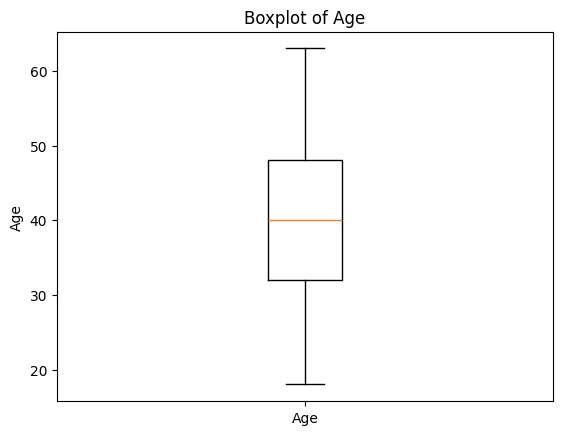

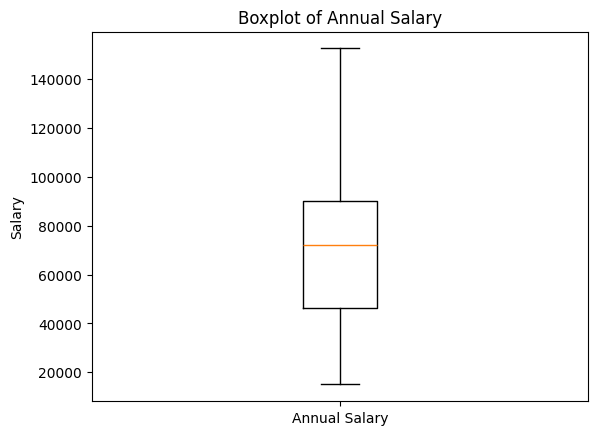

In [20]:
%matplotlib inline

# Boxplot for Age
plt.boxplot(df['Age'])
plt.xticks([1], ['Age'])
plt.title('Boxplot of Age')
plt.ylabel('Age')
plt.show()

# Boxplot for Annual Salary
plt.boxplot(df['AnnualSalary'])
plt.xticks([1], ['Annual Salary'])
plt.title('Boxplot of Annual Salary')
plt.ylabel('Salary')
plt.show()

In [8]:
df['Gender'] = df['Gender'].map({'Female': 1, 'Male': 0})

In [9]:
df['Gender'].value_counts()

Gender
1    516
0    484
Name: count, dtype: int64

In [10]:
df['Purchased'].value_counts()

Purchased
0    598
1    402
Name: count, dtype: int64

# Training

In [29]:
# Prepare the data
feature_names = ['Age', 'Gender', 'AnnualSalary']
X = df[feature_names]
y = df['Purchased']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Create base model
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=(df['Purchased'].value_counts()[0] / df['Purchased'].value_counts()[1] if df['Purchased'].value_counts()[1] > 0 else 1)
)

# Result
scores = cross_val_score(xgb, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
print(f"F1 Score: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

F1 Score: 0.8629 ± 0.0414


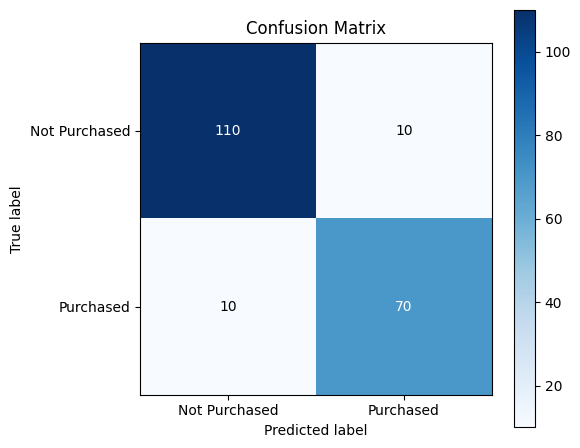

In [30]:
y_pred = xgb.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Purchased', 'Purchased'])
plt.yticks(tick_marks, ['Not Purchased', 'Purchased'])

# Add counts inside the squares
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [31]:
# Print classification metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Not Purchased', 'Purchased']))

Classification Report:

               precision    recall  f1-score   support

Not Purchased       0.92      0.92      0.92       120
    Purchased       0.88      0.88      0.88        80

     accuracy                           0.90       200
    macro avg       0.90      0.90      0.90       200
 weighted avg       0.90      0.90      0.90       200



# Final Model

In [28]:
# Prepare the data
feature_names = ['Age', 'Gender', 'AnnualSalary']
X = df[feature_names]
y = df['Purchased']

# Create base model
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=(df['Purchased'].value_counts()[0] / df['Purchased'].value_counts()[1] if df['Purchased'].value_counts()[1] > 0 else 1)
)

# Fit
model.fit(X, y)

# Dump the model to a file
dump(model,'model.joblib')

['model.joblib']